# AIN413 Machine Learning for HealthCare Course Project : Patient's Condition Classification Using Drug Reviews

**Due Date:** 31.05.2024

---------------------------------------

**Instructor:** Gülden Olgun


---------------------------------------
**Student Name Surname**: Melike Nur Dulkadir
**Student ID**: 21992919

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:2000/1*fpKIE34xAR22c2Ti50OHqw.jpeg" alt="Data Science Life Cycle" width="550">
</p>

## Introduction
In the healthcare domain, user reviews of medications provide valuable insights into the efficacy and side effects of various drugs. Leveraging machine learning to analyze these reviews can help categorize health conditions and understand user sentiment, aiding healthcare providers and patients in making informed decisions. This project aims to classify health conditions based on user reviews and perform sentiment analysis to gauge user satisfaction. Given the significant imbalance in the dataset, the project adopts a two-step classification approach: first predicting the broader health category and then identifying the specific condition within these categories.

The first step involves importing essential libraries for data manipulation, visualization, and machine learning tasks, including Pandas for data handling, Matplotlib and Seaborn for plotting, and scikit-learn for machine learning algorithms.

In [121]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS, WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore", category=Warning)

The following step involved examining the training data and handling missing values by removing rows with NaN values.

In [2]:
train_data = pd.read_csv('drugsComTrain_raw.csv')

In [3]:
train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
train_data.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [5]:
train_data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [6]:
train_data.dropna(inplace=True)

In [7]:
train_data.isnull().any()

uniqueID       False
drugName       False
condition      False
review         False
rating         False
date           False
usefulCount    False
dtype: bool

The condition distribution was highly imbalanced, with 884 unique conditions, where the most frequent condition (birth control) had 28,788 entries, and many conditions had only a single entry.

In [8]:
train_data.condition.value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

This function checks whether a comment contains a pattern indicating it is an unwanted comment, typically generated by users indicating the helpfulness of the comment. The pattern matches strings like "digits</span> users found this comment helpful."

In [9]:
def is_unwanted_comment(comment):
    pattern = re.compile(r'\d+</span> users found this comment helpful\.')
    return bool(pattern.match(comment))

In [10]:
filtered_train_data = train_data[~train_data['condition'].apply(is_unwanted_comment)]
value_counts = filtered_train_data['condition'].value_counts()
filtered_conditions = value_counts[value_counts > 900].index
filtered_train_data = filtered_train_data[filtered_train_data['condition'].isin(filtered_conditions)]
filtered_train_data.condition.value_counts()

condition
Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                

In [11]:
filtered_train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5


# Visualization of Filtered Data

This code segment creates a word cloud visualization, which is a graphical representation of word frequency in a text corpus, in this case, the drug names from the filtered training data. The WordCloud object is configured to generate a word cloud with an orange background color, excluding common stopwords, and specifying the dimensions of the image. By visualizing drug names in this way, it becomes easier to identify the most frequently mentioned drugs in the dataset.

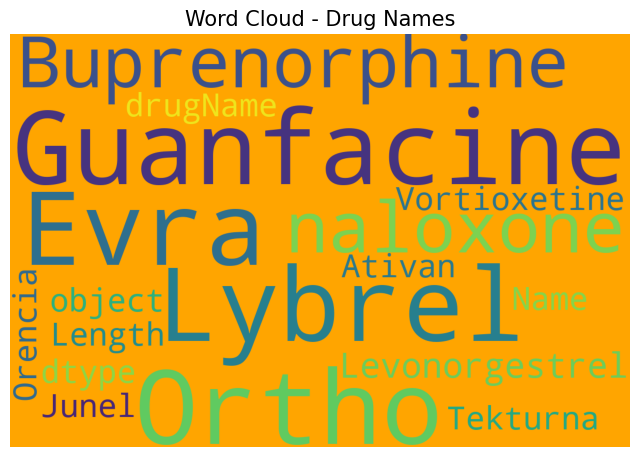

In [73]:
wordcloud = WordCloud(background_color = 'orange', stopwords = set(STOPWORDS), width = 1200, height = 800).generate(str(filtered_train_data['drugName']))

plt.rcParams['figure.figsize'] = (8, 8)
plt.title('Word Cloud - Drug Names', fontsize = 15)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

This code examines the drugs that received the highest number of ratings in the dataset. Levonorgestrel and Phentermine are identified as drugs with the highest number of ratings, each receiving a perfect score of 10/10. Conversely, Miconazole is noted for having the highest number of ratings, indicating potential user dissatisfaction. By visualizing the distribution of ratings for these drugs, we gain insights into their popularity and user satisfaction levels.

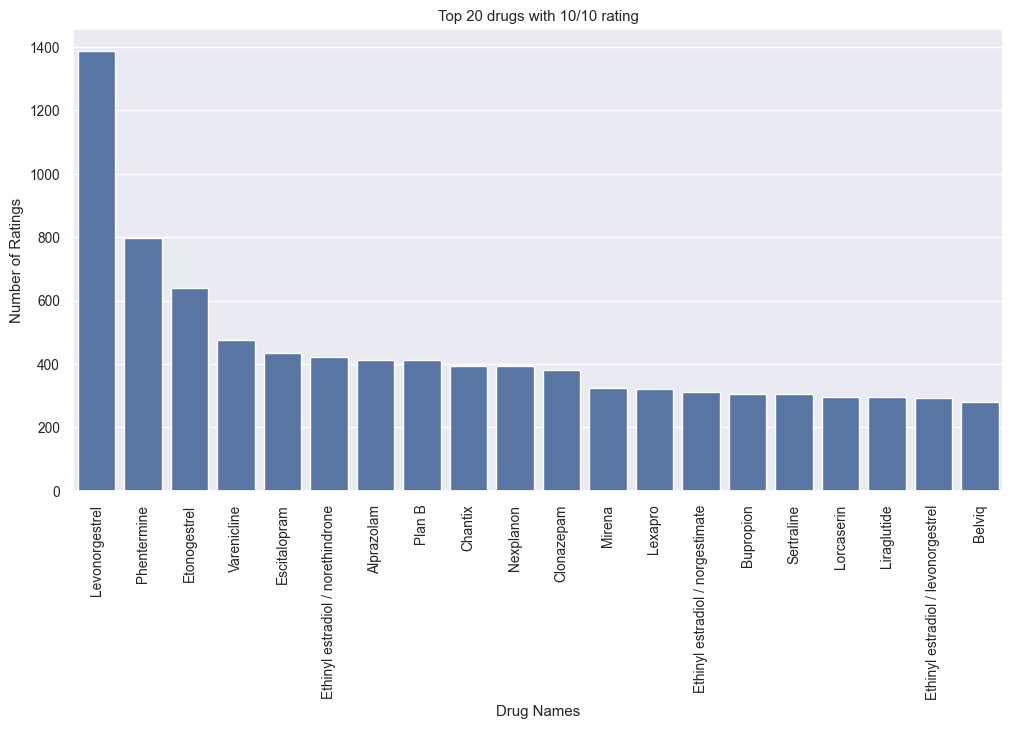

In [168]:
sns.set(font_scale = 0.9, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]

rating = dict(filtered_train_data.loc[filtered_train_data.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

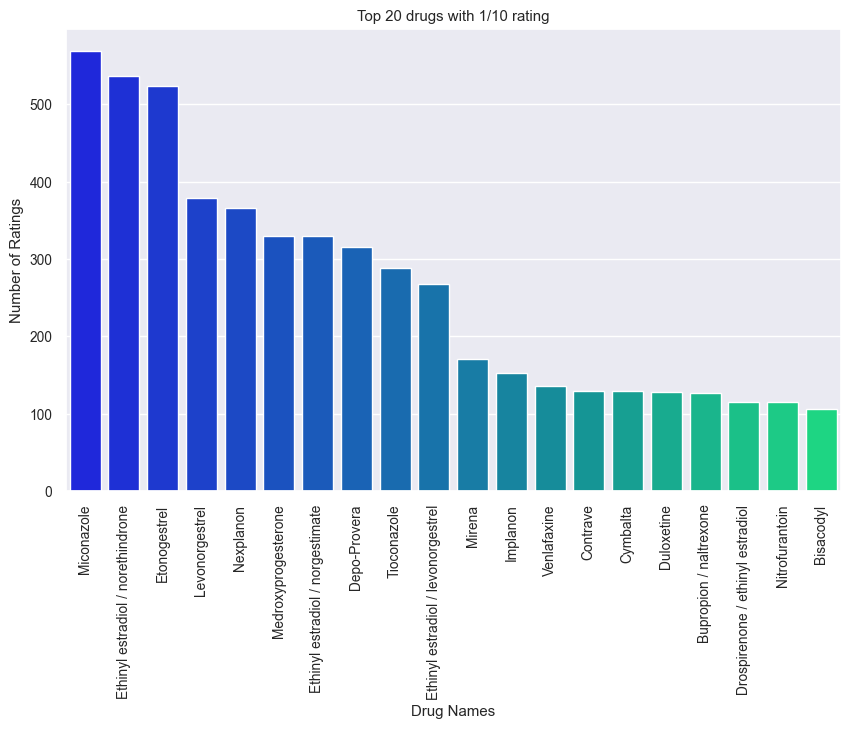

In [169]:
sns.set(font_scale = 0.9, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]

rating = dict(filtered_train_data.loc[filtered_train_data.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

This code segment creates a pie chart to illustrate the distribution of ratings in the filtered training data. It highlights that the highest number of reviews corresponded to a rating of 10, indicating that a significant portion of users provided perfect ratings for the drugs.

In [111]:
rating_counts = filtered_train_data.rating.value_counts()
rating_counts_list = rating_counts.tolist()

rating_values_list = filtered_train_data.rating.value_counts().index.tolist()

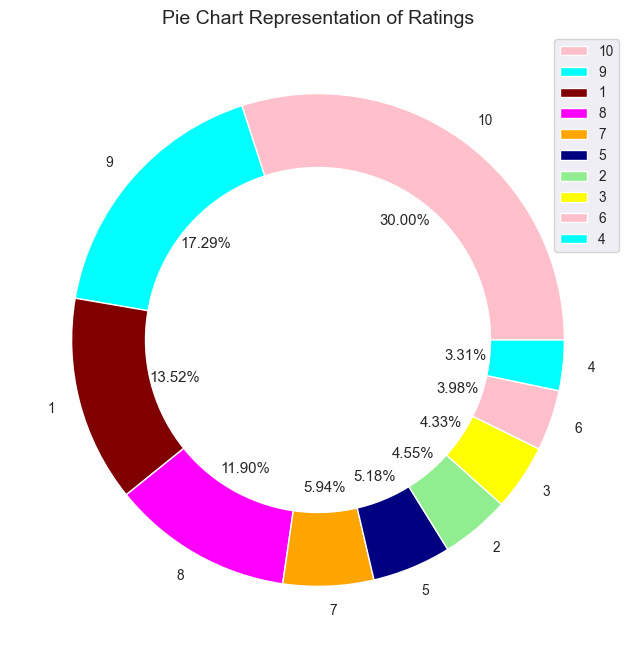

In [106]:
colors = ['pink', 'cyan', 'maroon',  'magenta', 'orange', 'navy', 'lightgreen', 'yellow']
labels = rating_values_list

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(rating_counts_list, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Ratings', fontsize = 14)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

This code segment generates a countplot to visualize the distribution of ratings in the filtered training data. It sets the style and font scale for the plot and uses seaborn's distplot function to display the distribution of ratings along the x-axis. By examining this plot, we can gain insights into the frequency of each rating value in the dataset.

Text(0.5, 0, 'Rating')

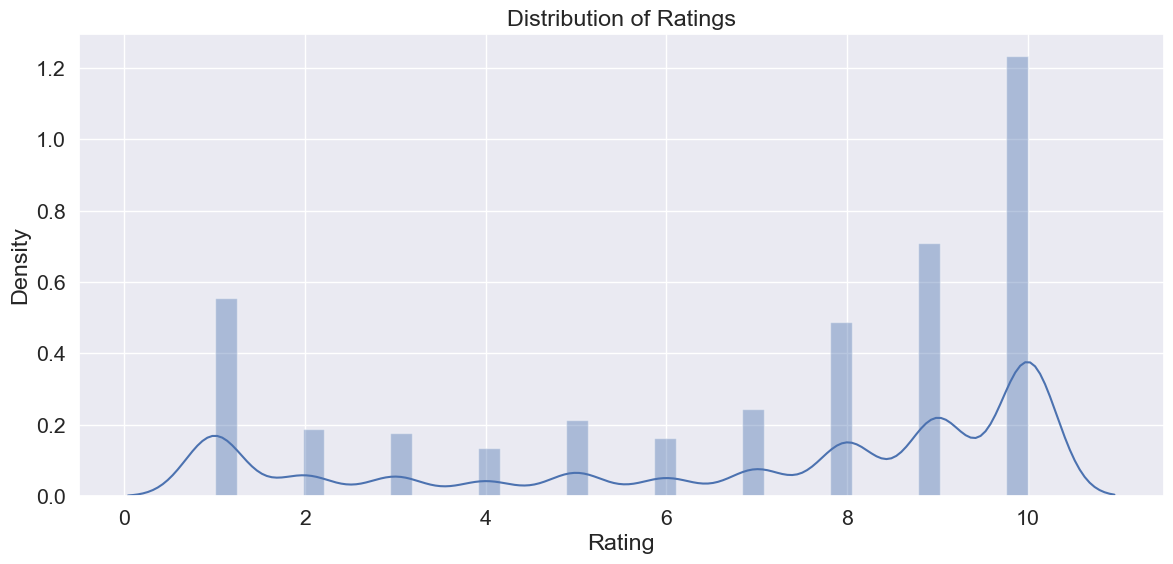

In [196]:
plt.rcParams['figure.figsize'] = [14, 6]
sns.set(font_scale=1.4, style='darkgrid')

sns_1 = sns.distplot(filtered_train_data['rating'])
sns_1.set_title('Distribution of Ratings')
sns_1.set_xlabel("Rating")

This code identifies and visualizes the top 10 conditions with the most reviews based on the filtered training data. The analysis reveals that the most frequently reported conditions are birth control, depression, and pain, indicating that these health issues are prominent among users.

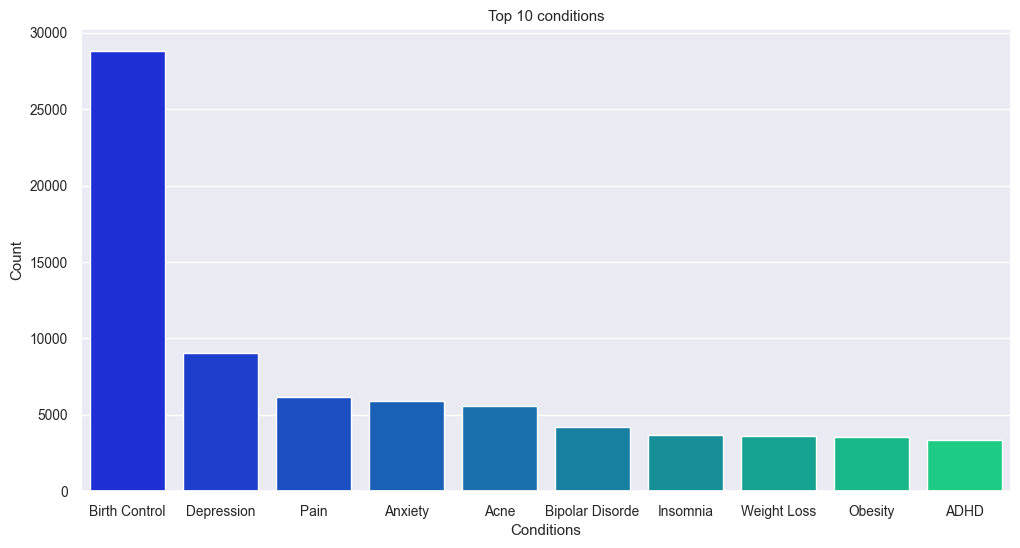

In [176]:
cond = dict(filtered_train_data['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 0.9)
plt.rcParams['figure.figsize'] = [12, 6]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count")

This code segment focuses on visualizing the top 10 drugs commonly used for the condition "Birth Control." It filters the dataset to include only entries related to birth control, extracts the counts of each drug used for this condition, and plots them as a bar plot using seaborn's barplot function. By examining this visualization, we can understand which drugs are most frequently prescribed or used for birth control purposes.

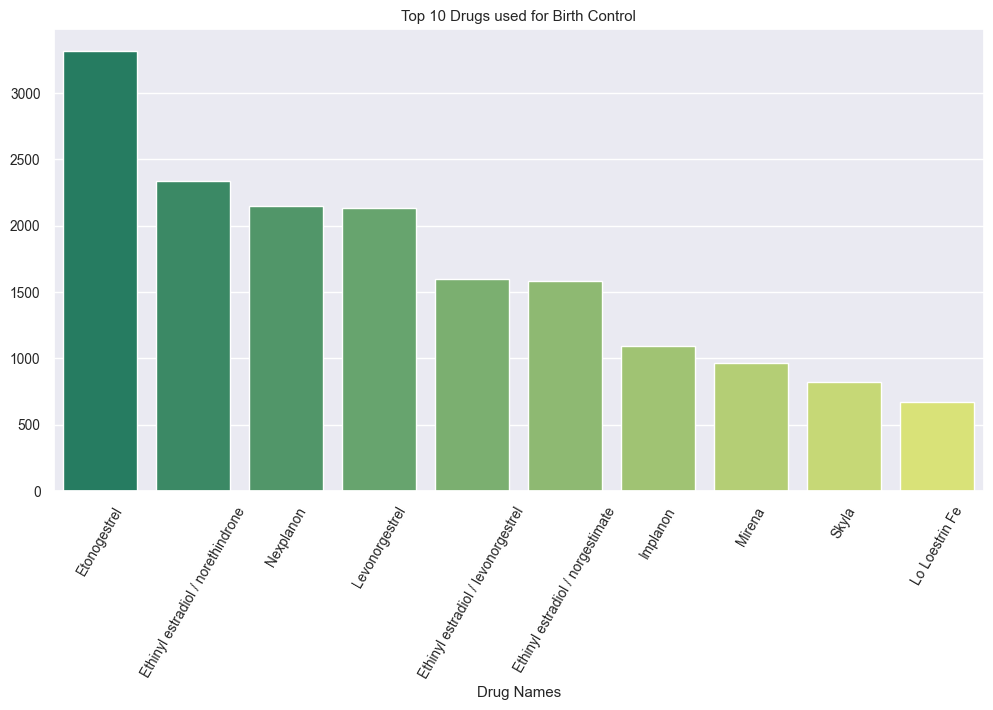

In [179]:
df1 = filtered_train_data[filtered_train_data['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 0.9, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 60)

# Categorizing

This code defines a function, categorize_health_condition, to classify health conditions into distinct categories based on predefined lists of mental health, physical health, and specialized health conditions. Each condition is evaluated against these lists, and if a match is found, it is categorized accordingly. Additionally, the condition "Birth Control" is treated as a separate category. The function is then applied to the "condition" column in the dataset (filtered_train_data), and the results are stored in a new column named "category," providing a structured classification of health conditions for further analysis.

In [12]:
def categorize_health_condition(condition):
    mental_health_conditions = ['Depression', 'Anxiety' ,'Bipolar Disorde','Panic Disorde', 'Major Depressive Disorde', 'Generalized Anxiety Disorde', 'ADHD', 'Anxiety and Stress']
    physical_health_conditions = [
         'Insomnia', 'Weight Loss', 'Obesity', 'Diabetes, Type 2', 'ibromyalgia',
        'Emergency Contraception', 'High Blood Pressure', 'Vaginal Yeast Infection', 'Abnormal Uterine Bleeding',
        'Bowel Preparation', 'Fibromyalgia', 'Smoking Cessation'
    ]
    specialized_health_conditions = [
        'Migraine', 'Pain', 'Constipation', 'Acne', 'Chronic Pain', 'Migraine Prevention', 'Urinary Tract Infection', 'Muscle Spasm', 'Osteoarthritis',
         'Erectile Dysfunction', 'Opiate Dependence', 'Irritable Bowel Syndrome',
        'Rheumatoid Arthritis', 'Allergic Rhinitis', 'Bacterial Infection', 'Cough'
    ]
    if condition in mental_health_conditions:
        return 'Mental Health'
    elif condition in physical_health_conditions:
        return 'Physical Health'
    elif condition in specialized_health_conditions:
        return 'Specialized Health'
    elif condition == 'Birth Control':
        return 'Birth Control'
    else:
        return 'Other'

filtered_train_data['category'] = filtered_train_data['condition'].apply(categorize_health_condition)

In [13]:
filtered_train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,category
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Mental Health
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Birth Control
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Birth Control
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Specialized Health
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,Physical Health


## BEFORE PREPROCESSING

This section provides an overview of the healthcare dataset in its original form, before any cleaning or adjustments are made. In our project, data cleaning is the first step where we organize and refine the dataset for analysis. The "Before Data Cleaning" segment offers a straightforward view of the dataset's initial condition, helping us understand its raw content before any modifications are implemented. This initial stage sets the stage for further analysis by establishing a baseline understanding of the dataset's starting point.

In [14]:
test_data = pd.read_csv("drugsComTest_raw.csv")
filtered_test_data = test_data[test_data['condition'].isin(filtered_conditions)]

In [15]:
filtered_test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1


#### TF-IDF (Term Frequency-Inverse Document Frequency) is a widely used technique for converting text documents into numerical vectors. It quantifies the importance of words in a document corpus.

- Term Frequency (TF): Measures how often a word appears in a document. A high TF value indicates that a word is frequently present in the document.
- Inverse Document Frequency (IDF): Measures how common a word is across all documents. A logarithmic scale is used to give greater weight to rare words.
TfidfVectorizer transforms text data based on these TF-IDF features. As a result, each document is represented by a vector of TF-IDF scores. This vectorization method is commonly used in various natural language processing tasks such as text classification, clustering, and information retrieval.

In [56]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(filtered_train_data.review)

In [57]:
label_encoder = LabelEncoder()
filtered_train_data['category_encoded'] = label_encoder.fit_transform(filtered_train_data['category'])
y_train = filtered_train_data.category_encoded

In [58]:
filtered_test_data['category'] = filtered_test_data['condition'].apply(categorize_health_condition)

In [59]:
y_test = label_encoder.transform(filtered_test_data['category'])

In [16]:
X_test = tfidf_vectorizer.transform(filtered_test_data.review)

In [43]:
def modelling(tfidf_vectors,y_train,X_test,y_test):
    # Initialize the models
    knn = KNeighborsClassifier()
    log_reg = LogisticRegression(max_iter=1000)  
    decision_tree = DecisionTreeClassifier()
    svm = SVC()
    random_forest = RandomForestClassifier()
    
    # Dictionary to store models and their respective accuracies
    models = {
        'K-Nearest Neighbors': knn,
        'Logistic Regression': log_reg,
        'Decision Tree': decision_tree,
        'Support Vector Machine': svm,
        'Random Forest': random_forest,
    }
    
    # Dictionary to store accuracies
    accuracies = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(model_name)
        
        # Train the model
        model.fit(tfidf_vectors, y_train)
        print(model_name+ " trained")
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(accuracy)
        accuracies[model_name] = accuracy

In [21]:
# Without random forest model
modelling(tfidf_vectors,y_train,X_test,y_test)

K-Nearest Neighbors
K-Nearest Neighbors trained
0.8169601847720532
Logistic Regression
Logistic Regression trained
0.9152515682003097
Decision Tree
Decision Tree trained
0.9060129655389623
Support Vector Machine
Support Vector Machine trained
0.9482690743025117


# NLP

This code block comprises functions designed for preprocessing textual data. Each function serves a specific preprocessing task:

- remove_numbers(text): Eliminates numerical digits from the text using regular expressions.
- clean_punctuation(str_text_raw): Converts the text to lowercase.
- Removes punctuation marks from the text using regular expressions.
- remove_stop_words(text): Eliminates common English stop words from the text using NLTK's predefined list.
- remove_short_words(text): Filters out words with less than three characters.
- tokenizer(words): Splits the text into individual words.
- lemmatization(words): Converts words into their base forms using lemmatization.
These functions collectively form a preprocessing pipeline aimed at refining textual data by removing noise, such as numbers and punctuation, eliminating stop words, and standardizing word forms through lemmatization. The resulting processed text is then ready for further analysis or modeling tasks.

In [16]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def clean_punctuation(str_text_raw):
    str_text_raw = str_text_raw.lower()
    str_text = re.sub("[$\(\)/|{|\}#~\[\]^#;:!?%¿_,.'\"']", " ", str_text_raw)
    return(re.sub(r'\.{3}', " ", str_text))

# Load stop words
stop_words = set(stopwords.words('english'))
def remove_stop_words(text):
    cleaned_text = " ".join([word for word in text.split() if word not in stop_words])
    return cleaned_text

def remove_short_words(text):
    pattern = r'\b\w{1,2}\b'
    return re.sub(pattern, '', text)

def tokenizer(words):
    tokenizer = RegexpTokenizer(r'\w+')
    words= tokenizer.tokenize(words)
    return words

def lemmatization(words):
    wnetlemmatizer =  WordNetLemmatizer()
    
    lemmatized = []
    for w in words:
        lemmatized.append(wnetlemmatizer.lemmatize(w))
    return lemmatized 

In [17]:
def text_preprocessing(text):
    text = remove_numbers(text)
    text = clean_punctuation(text)
    text = " ".join(x.strip() for x in text.split())
    text = remove_stop_words(text)
    text =  remove_short_words(text)
    text = " ".join(x.strip() for x in text.split())
    text = tokenizer(text)
    text = lemmatization(text)
    return text

This code utilizes the spaCy library to perform named entity recognition (NER) on text data. By loading the pre-trained English language model, the function processes the input text to identify and extract named entities, such as names of people, organizations, and dates. The function then returns these entities along with their corresponding labels, facilitating the extraction and classification of key information from the text.

In [18]:
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(entity.text, entity.label_) for entity in doc.ents]

In [19]:
preprocessed_train_data = filtered_train_data.copy()
preprocessed_test_data = filtered_test_data.copy()

In [20]:
preprocessed_train_data['entities'] = preprocessed_train_data['review'].apply(extract_entities)
preprocessed_test_data['entities'] = preprocessed_test_data['review'].apply(extract_entities)

This code defines a function to extract unique entity labels from a list of entities. The function get_unique_entity_labels iterates through lists of entities, collecting unique labels into a set. It then applies this function to the 'entities' column of the preprocessed training data to obtain a list of all unique entity labels. This helps in understanding the variety of entities present in the dataset.

In [53]:
def get_unique_entity_labels(entities):
    labels = set()
    for entity_list in entities:
        for _, label in entity_list:
            labels.add(label)
    return labels

all_entities = preprocessed_train_data['entities'].tolist()
unique_labels = get_unique_entity_labels(all_entities)
unique_labels

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

- CARDINAL: Numerical expressions (e.g., "two", "100", "3.14"). Exact numbers without a specific unit of measurement.
- DATE: Dates or historical events (e.g., "21st July", "1990", "Monday").
- EVENT: Events, meetings, wars, sports events, etc. (e.g., "Olympics", "World War II").
- FAC: Physical locations such as buildings, airports, highways, bridges, etc. (e.g., "Eiffel Tower", "Route 66").
- GPE: Political or geographical entities like countries, cities, states, etc. (e.g., "United States", "Paris", "California").
- LANGUAGE: Names of languages (e.g., "English", "Spanish").
- LAW: Legal documents and laws (e.g., "First Amendment").
- LOC: Geographical regions, seas, mountains, etc. (e.g., "Atlantic Ocean", "Mount Everest").
- MONEY: Monetary amounts with currency units (e.g., "$100", "500 euros").
- NORP: Nationalities, religious or political groups (e.g., "American", "Christian", "Democrat").
- ORDINAL: Expressions indicating order (e.g., "first", "second", "third").
- ORG: Companies, agencies, institutions, organizations (e.g., "Google", "FBI", "UN").
- PERCENT: Percentage expressions (e.g., "50%", "20 percent").
- PERSON: Names of individuals (e.g., "John", "Jane Doe").
- PRODUCT: Products, brands (e.g., "iPhone", "Nike Air").
- QUANTITY: Amounts with measurement units (e.g., "10 kg", "2 liters").
- TIME: Time expressions (e.g., "2 PM", "morning").
- WORK_OF_ART: Artworks, books, songs, movies, etc. (e.g., "Mona Lisa", "War and Peace").

This code defines functions for extracting and removing specific entities from text data, focusing on cleaning the reviews by removing irrelevant information. The extract_entities function filters entities based on a given label, while the remove_entities function removes these entities from the text. The code then applies these functions to both the training and test datasets, targeting entities with the labels 'CARDINAL', 'TIME', and 'DATE'. By updating the datasets with filtered reviews that exclude these entities, the data becomes cleaner and more relevant for subsequent analysis.

In [ ]:
def extract_entities(entities, label):
    return [entity for entity, entity_label in entities if entity_label == label]

def remove_entities(review, entities):
    for entity in entities:
        review = review.replace(entity, "")
    return review

In [24]:
labels = ['CARDINAL', 'TIME','DATE']
for label in labels:
    preprocessed_train_data[label.lower()] = preprocessed_train_data['entities'].apply(
        lambda entities: extract_entities(entities, label)
    )
    preprocessed_train_data['filtered_review'] = preprocessed_train_data.apply(
        lambda row: remove_entities(row['review'], row[label.lower()]), axis=1
    )
    preprocessed_test_data[label.lower()] = preprocessed_test_data['entities'].apply(
        lambda entities: extract_entities(entities, label)
    )
    preprocessed_test_data['filtered_review'] = preprocessed_test_data.apply(
        lambda row: remove_entities(row['review'], row[label.lower()]), axis=1
    )

In [25]:
preprocessed_train_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,category,entities,cardinal,filtered_review,time
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"[his fourth week, this last week, two days, Mo...",192,Mental Health,"[(his fourth week, DATE), (Intuniv, ORG), (thi...",[],"""My son is halfway through of Intuniv. We bec...","[nearly 8 hours, morning, the morning]"
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"[5 days, my first day of period, two weeks, tw...",17,Birth Control,"[(21, CARDINAL), (5 days, DATE), (US, GPE), (L...",[21],"""I used to take another oral contraceptive, wh...",[]
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"[8 months, 5-6 days, 3-4 days, the first two d...",10,Birth Control,"[(first, ORDINAL), (8 months, DATE), (5-6 days...",[],"""This is my first time using any form of birth...",[]
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,[years],37,Specialized Health,"[(Suboxone, ORG), (Suboxone, ORG), (years, DAT...",[],"""Suboxone has completely turned my life around...",[]
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,[two weeks later],5,Physical Health,"[(the Plan B 26 hours, LAW), (two weeks later,...",[],"""He pulled out, but he cummed a bit in me. I t...",[]
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,"[the age of 15, daily, 21]",32,Mental Health,"[(Zoloft, PERSON), (Clonidine, PERSON), (Abili...","[2, 5, 2x]","""Abilify changed my life. There is hope. I was...",[]
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,"[many years, about 6 months, age 28, today]",1,Birth Control,"[(many years, DATE), (RX, ORG), (about 6 month...",[],"""I had been on the pill for . When my doctor c...",[]
10,29607,Topiramate,Migraine Prevention,"""I have been on this medication almost two wee...",9,"[two weeks, a week]",19,Specialized Health,"[(two weeks, DATE), (25, CARDINAL), (up to 100...","[25, up to 100, 50, 2-3, 5.2lbs]","""I have been on this medication almost , start...",[]
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,"[years, about 3 months]",54,Mental Health,"[(years, DATE), (Cymbalta, ORG), (Deplin, GPE)...",[],"""I have taken anti-depressants for , with some...",[]
13,221320,Dextromethorphan,Cough,"""Have a little bit of a lingering cough from a...",4,[],1,Specialized Health,"[(night, TIME), (Delsym, ORG), (first, ORDINAL)]",[],"""Have a little bit of a lingering cough from a...",[night]


This code further preprocesses the text data by applying a text_preprocessing function to the filtered reviews, then converts tokenized words back into a single string format for both the training and test datasets.

In [27]:
preprocessed_train_data["filtered_review"] = preprocessed_train_data["filtered_review"].apply(text_preprocessing)
preprocessed_test_data["filtered_review"] = preprocessed_test_data["filtered_review"].apply(text_preprocessing)

In [29]:
def convert_str(words):
    result = " ".join(words)
    return result

In [30]:
preprocessed_train_data["filtered_review"] = preprocessed_train_data["filtered_review"].apply(convert_str)
preprocessed_test_data["filtered_review"] = preprocessed_test_data["filtered_review"].apply(convert_str)

In [31]:
preprocessed_train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,category,entities,cardinal,filtered_review,time
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"[his fourth week, this last week, two days, Mo...",192,Mental Health,"[(his fourth week, DATE), (Intuniv, ORG), (thi...",[],son halfway intuniv became concerned began sta...,"[nearly 8 hours, morning, the morning]"
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"[5 days, my first day of period, two weeks, tw...",17,Birth Control,"[(21, CARDINAL), (5 days, DATE), (US, GPE), (L...",[21],used take another oral contraceptive pill cycl...,[]
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"[8 months, 5-6 days, 3-4 days, the first two d...",10,Birth Control,"[(first, ORDINAL), (8 months, DATE), (5-6 days...",[],first time using form birth control glad went ...,[]
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,[years],37,Specialized Health,"[(Suboxone, ORG), (Suboxone, ORG), (years, DAT...",[],suboxone completely turned life around feel he...,[]
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,[two weeks later],5,Physical Health,"[(the Plan B 26 hours, LAW), (two weeks later,...",[],pulled cummed bit took plan hour later took pr...,[]


The modelling process begins by setting up a TfidfVectorizer with specific parameters tailored for converting preprocessed text data into TF-IDF features. Following this setup, the training and test datasets undergo transformation using this vectorizer. The resulting transformed data is then employed for training and evaluating models.

In [60]:
new_tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', use_idf = True, smooth_idf= True)
new_X_train = new_tfidf_vectorizer.fit_transform(preprocessed_train_data.filtered_review)

In [62]:
new_X_test = new_tfidf_vectorizer.transform(preprocessed_test_data.filtered_review)

In [63]:
modelling(new_X_train,y_train,new_X_test,y_test)

K-Nearest Neighbors
K-Nearest Neighbors trained
0.2539565890659038
Logistic Regression
Logistic Regression trained
0.9265111151938269
Decision Tree
Decision Tree trained
0.9084276003254508
Support Vector Machine
Support Vector Machine trained
0.9503425106952573
Random Forest
Random Forest trained
0.9451457966982494


The results reveal compelling insights. Support Vector Machines (SVM) and Logistic Regression models showcase significantly higher accuracy rates in comparison to others, underscoring their efficacy in health condition classification. Nevertheless, K-Nearest Neighbors and Decision Trees still present respectable accuracy values. These findings collectively suggest the potential effectiveness of diverse model types in health condition classification.

# Physical Health

The code snippet is designed to address the classification task concerning physical health conditions within the dataset. Initially, the training and test datasets are filtered to include only entries relevant to the 'Physical Health' category. Following this, a TF-IDF vectorizer is employed to convert the textual input data into numerical feature representations. Additionally, label encoding is applied to transform categorical condition labels into numerical values for compatibility with model training. Finally, the transformed data is utilized to train and evaluate models specifically tailored for classifying physical health conditions.

In [55]:
df_physical_health_train = preprocessed_train_data[preprocessed_train_data['category'] == 'Physical Health']
df_physical_health_test = preprocessed_test_data[preprocessed_test_data['category'] == 'Physical Health']

physical_health_tfidf_vectorizer = TfidfVectorizer()
physical_health_X_train = physical_health_tfidf_vectorizer.fit_transform(df_physical_health_train.filtered_review)

physical_health_label_encoder = LabelEncoder()
df_physical_health_train['condition_encoded'] = physical_health_label_encoder.fit_transform(df_physical_health_train['condition'])
physical_health_y_train = df_physical_health_train.condition_encoded

physical_health_X_test = physical_health_tfidf_vectorizer.transform(df_physical_health_test.filtered_review)
physical_health_y_test = physical_health_label_encoder.transform(df_physical_health_test['condition'])

In [50]:
modelling(physical_health_X_train,physical_health_y_train, physical_health_X_test,physical_health_y_test)

K-Nearest Neighbors
K-Nearest Neighbors trained
0.7515653189005624
Logistic Regression
Logistic Regression trained
0.878594927305529
Decision Tree
Decision Tree trained
0.8664968693621988
Support Vector Machine
Support Vector Machine trained
0.9248646927730022
Random Forest
Random Forest trained
0.9215748699989388


The results indicate that Support Vector Machines (SVM) and Logistic Regression models achieve notably higher accuracy rates compared to the other models in classifying physical health conditions. SVM, in particular, demonstrates the highest accuracy, followed closely by Logistic Regression. While K-Nearest Neighbors, Decision Trees, and Random Forests also provide respectable accuracy values, they fall slightly short of the performance achieved by SVM and Logistic Regression. These findings suggest that SVM and Logistic Regression may be more effective for this specific classification task within the physical health domain. 

# Mental Health

This code segment focuses on classifying text data related to mental health conditions. Initially, the training and test datasets are filtered to include only entries relevant to the 'Mental Health' category. Subsequently, a TF-IDF vectorizer is applied to convert the textual input data into numerical feature representations. Additionally, label encoding is utilized to transform categorical condition labels into numerical values suitable for model training. Finally, the transformed data is used to train and evaluate models specifically tailored for classifying mental health conditions.

In [51]:
df_mental_health_train = preprocessed_train_data[preprocessed_train_data['category'] == 'Mental Health']
df_mental_health_test = preprocessed_test_data[preprocessed_test_data['category'] == 'Mental Health']

mental_health_tfidf_vectorizer = TfidfVectorizer()
mental_health_X_train = mental_health_tfidf_vectorizer.fit_transform(df_mental_health_train.filtered_review)

mental_health_label_encoder = LabelEncoder()
df_mental_health_train['condition_encoded'] = mental_health_label_encoder.fit_transform(df_mental_health_train['condition'])
mental_health_y_train = df_mental_health_train.condition_encoded

mental_health_X_test = mental_health_tfidf_vectorizer.transform(df_mental_health_test.filtered_review)
mental_health_y_test = mental_health_label_encoder.transform(df_mental_health_test['condition'])

In [52]:
modelling(mental_health_X_train,mental_health_y_train, mental_health_X_test,mental_health_y_test)

K-Nearest Neighbors
K-Nearest Neighbors trained
0.49233047709721783
Logistic Regression
Logistic Regression trained
0.6957579604358405
Decision Tree
Decision Tree trained
0.7927642018406855
Support Vector Machine
Support Vector Machine trained
0.7948799322966255
Random Forest
Random Forest trained
0.8396276314397546


The results show varying degrees of accuracy across different classification models for mental health conditions. Among these models, Random Forest achieved the highest accuracy, followed closely by Support Vector Machine (SVM). Decision Tree also performed relatively well, while Logistic Regression and K-Nearest Neighbors (KNN) exhibited lower accuracy rates compared to the other models. These findings suggest that Random Forest and SVM may be more effective in classifying mental health conditions based on the provided textual data. 

# Specialized Health

The following code prepares the training and test datasets for the specialized health category. It involves steps such as generating TF-IDF vector representations for text data, label encoding for conditions, and splitting the data into training and test sets. Then, the "modelling" function is employed to train and evaluate various classification models to predict relevant medical conditions based on processed text reviews.

In [44]:
df_specialized_health_train = preprocessed_train_data[preprocessed_train_data['category'] == 'Specialized Health']
df_specialized_health_test = preprocessed_test_data[preprocessed_test_data['category'] == 'Specialized Health']

specialized_health_tfidf_vectorizer = TfidfVectorizer()
specialized_health_X_train = specialized_health_tfidf_vectorizer.fit_transform(df_specialized_health_train.filtered_review)

specialized_health_label_encoder = LabelEncoder()
df_specialized_health_train['condition_encoded'] = specialized_health_label_encoder.fit_transform(df_specialized_health_train['condition'])
specialized_health_y_train = df_specialized_health_train.condition_encoded

specialized_health_X_test = specialized_health_tfidf_vectorizer.transform(df_specialized_health_test.filtered_review)
specialized_health_y_test = specialized_health_label_encoder.transform(df_specialized_health_test['condition'])

In [45]:
modelling(specialized_health_X_train,specialized_health_y_train, specialized_health_X_test, specialized_health_y_test)

K-Nearest Neighbors
K-Nearest Neighbors trained
0.6839302495562285
Logistic Regression
Logistic Regression trained
0.8423305836900908
Decision Tree
Decision Tree trained
0.8470293411297901
Support Vector Machine
Support Vector Machine trained
0.8844105669833977
Random Forest
Random Forest trained
0.8875430719431973


The results for the specialized health category exhibit a notable performance across all models. Logistic Regression, Decision Tree, Support Vector Machine, and Random Forest achieve relatively high accuracy scores, ranging from approximately 84% to 89%. This suggests that these models are effective in classifying specialized health conditions based on textual reviews. K-Nearest Neighbors, while still achieving a decent accuracy score of around 68%, falls short compared to the other models in this category. Overall, these results indicate promising outcomes for predicting specialized health conditions using machine learning algorithms.

# Final Models
After observations, final models were constructed using the models that yielded the best results, and their performance was evaluated using various metrics.

This code performs hyperparameter tuning for a Support Vector Machine (SVM) classifier using GridSearchCV. It explores different combinations of hyperparameters such as 'C' (regularization parameter), 'gamma' (kernel coefficient), and 'kernel' (kernel type) to find the best performing model. Once the hyperparameters are tuned, it prints out the best parameters found and the corresponding best score achieved during the grid search. Finally, it predicts the target labels for the test set using the tuned model and generates a classification report, which provides metrics such as precision, recall, and F1-score for each class in the classification task.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svc = SVC()

param_grid = {
    'C': [0.1, 1],
    'gamma': ['scale'],
    'kernel': ['linear', 'rbf', 'poly']
}

grid = GridSearchCV(svc, param_grid, refit=True, verbose=2)
grid.fit(physical_health_X_train, physical_health_y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

y_pred = grid.predict(physical_health_X_test)
print(classification_report(physical_health_y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 2.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 4.8min
[CV] END ....................C=0.1, gamma=scale, 

After conducting hyperparameter tuning, it was observed that the default parameters yielded better results, and therefore, the default parameters were retained for further analysis.

In [68]:
# main model
main_svc_model = SVC()
main_svc_model.fit(new_X_train, y_train)

SVC()

In [123]:
new_y_pred = main_svc_model.predict(new_X_test)
print(classification_report(y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9648
           1       0.95      0.96      0.95      9453
           2       0.95      0.91      0.93      9423
           3       0.94      0.95      0.94      9577

    accuracy                           0.95     38101
   macro avg       0.95      0.95      0.95     38101
weighted avg       0.95      0.95      0.95     38101



In [64]:
physical_health_model = SVC()
physical_health_model.fit(physical_health_X_train, physical_health_y_train)

SVC()

In [124]:
physical_health_y_pred = physical_health_model.predict(physical_health_X_test)
print(classification_report(physical_health_y_test, physical_health_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       648
           1       1.00      0.98      0.99       639
           2       0.94      0.92      0.93       808
           3       0.99      0.98      0.99       827
           4       0.90      0.94      0.92       783
           5       0.91      0.97      0.94      1231
           6       0.84      0.80      0.82      1189
           7       0.99      0.96      0.97       660
           8       0.98      0.97      0.98       811
           9       0.83      0.86      0.85      1248
          10       0.95      0.90      0.93       579

    accuracy                           0.92      9423
   macro avg       0.94      0.93      0.94      9423
weighted avg       0.93      0.92      0.92      9423



In [65]:
mental_health_model = RandomForestClassifier()
mental_health_model.fit(mental_health_X_train, mental_health_y_train)

RandomForestClassifier()

In [125]:
mental_health_y_pred = mental_health_model.predict(mental_health_X_test)
print(classification_report(mental_health_y_test, mental_health_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1126
           1       0.78      0.86      0.82      1908
           2       0.99      0.49      0.66       573
           3       0.93      0.87      0.90      1380
           4       0.77      0.96      0.85      3095
           5       0.99      0.49      0.66       378
           6       1.00      0.69      0.81       524
           7       0.94      0.59      0.72       469

    accuracy                           0.84      9453
   macro avg       0.92      0.74      0.80      9453
weighted avg       0.86      0.84      0.84      9453



In [66]:
specialized_health_model = RandomForestClassifier()
specialized_health_model.fit(specialized_health_X_train, specialized_health_y_train)

RandomForestClassifier()

In [126]:
specialized_health_y_pred = specialized_health_model.predict(specialized_health_X_test)
print(classification_report(specialized_health_y_test, specialized_health_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1847
           1       0.95      0.87      0.91       350
           2       0.87      0.65      0.74       307
           3       0.96      0.50      0.66       485
           4       0.91      0.93      0.92       525
           5       0.94      0.92      0.93       297
           6       0.94      0.94      0.94       381
           7       0.97      0.83      0.90       325
           8       0.88      0.89      0.88       583
           9       0.91      0.85      0.88       454
          10       0.91      0.78      0.84       387
          11       0.97      0.93      0.95       398
          12       0.94      0.79      0.86       387
          13       0.76      0.97      0.85      2100
          14       0.98      0.80      0.88       320
          15       0.93      0.88      0.91       431

    accuracy                           0.89      9577
   macro avg       0.92   

# Examples

In [198]:
def predict_condition(example):
    example_list = [example]
    category = main_svc_model.predict(new_tfidf_vectorizer.transform(example_list))
    category_label = label_encoder.inverse_transform(category)
    
    if category_label == "Mental Health":
        predicted_condition = mental_health_model.predict(mental_health_tfidf_vectorizer.transform(example_list))
        condition = mental_health_label_encoder.inverse_transform(predicted_condition)
        return condition
    elif category_label == "Physical Health":
        predicted_condition = physical_health_model.predict(physical_health_tfidf_vectorizer.transform(example_list))
        condition = physical_health_label_encoder.inverse_transform(predicted_condition)
        return condition
    elif category_label == "Specialized Health":
        predicted_condition = specialized_health_model.predict(specialized_health_tfidf_vectorizer.transform(example_list))
        condition = specialized_health_label_encoder.inverse_transform(predicted_condition)
        return condition
    else:
        return "Birth Control"

In [199]:
ex1 = preprocessed_test_data.loc[0].filtered_review
predict_condition(ex1)

array(['Depression'], dtype=object)

In [200]:
preprocessed_test_data.loc[0].condition

'Depression'

In [201]:
ex2 = preprocessed_test_data.loc[3].filtered_review
predict_condition(ex2)

array(['Weight Loss'], dtype=object)

In [202]:
preprocessed_test_data.loc[3].condition

'Weight Loss'

In [204]:
ex3 = preprocessed_test_data.loc[4].filtered_review
predict_condition(ex3)

'Birth Control'

In [205]:
preprocessed_test_data.loc[4].condition

'Birth Control'

In [207]:
ex4 = preprocessed_test_data.loc[7].filtered_review
predict_condition(ex4)

array(['Migraine Prevention'], dtype=object)

In [208]:
preprocessed_test_data.loc[7].condition

'Migraine Prevention'

# Sentiment
In this section, sentiment analysis is conducted on the dataset, aiming to assess the emotional tone of the reviews. The VADER (Valence Aware Dictionary and sEntiment Reasoner) tool from NLTK (Natural Language Toolkit) is utilized for this purpose. Each review's sentiment is evaluated based on its polarity, distinguishing between negative, neutral, and positive sentiments. This analysis provides insights into the overall emotional content of the reviews, aiding in understanding customer opinions and attitudes towards the discussed topics.

The code segment initializes a new DataFrame sentiment_data by making a copy of the preprocessed training data. It then assigns binary labels to each review based on their ratings: reviews with a rating of 5 or higher are labeled as positive sentiment (1), while those with a rating below 5 are labeled as negative sentiment (0). Afterward, it generates a pie chart visualizing the distribution of positive and negative sentiments in the dataset.

In [185]:
sentiment_data = preprocessed_train_data.copy()

sentiment_data.loc[(sentiment_data['rating'] >= 5), 'Review_Sentiment'] = 1
sentiment_data.loc[(sentiment_data['rating'] < 5), 'Review_Sentiment'] = 0

sentiment_data['Review_Sentiment'].value_counts()

Review_Sentiment
1.0    84663
0.0    29298
Name: count, dtype: int64

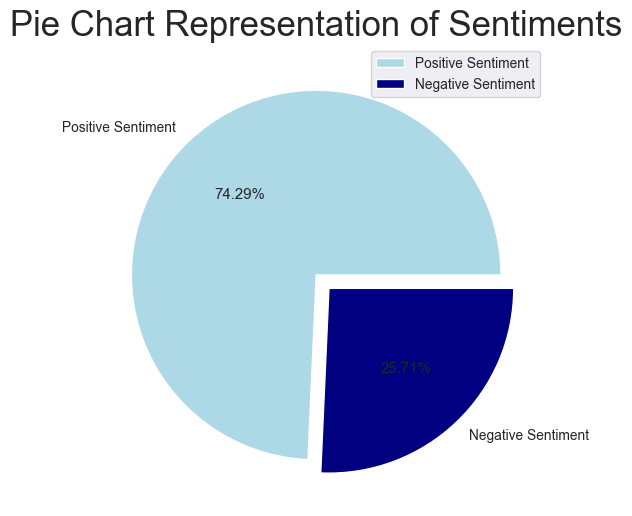

In [186]:
size = [84663, 29298]
colors = ['lightblue', 'navy']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

The pie chart provides a visual representation of the sentiment distribution within the dataset. It indicates that the majority of reviews, accounting for approximately 74.3% of the dataset, are labeled as positive sentiment (1.0), while the remaining approximately 25.7% of reviews are labeled as negative sentiment (0.0). This visualization helps in understanding the imbalance between positive and negative sentiments in the dataset.

The code segment downloads the VADER lexicon from NLTK, which is a lexicon and rule-based sentiment analysis tool specifically designed for analyzing sentiments in text. Then, it defines a function called analyze_sentiment(review) that takes a review as input and returns a dictionary of sentiment scores using the VADER sentiment analyzer. Finally, it applies this function to the 'filtered_review' column of the 'sentiment_data' DataFrame to analyze the sentiment of each review and store the sentiment scores in a new column named 'sentiment'.

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(review):
    scores = sid.polarity_scores(review)
    return scores

sentiment_data['sentiment'] = sentiment_data['filtered_review'].apply(analyze_sentiment)

In [188]:
sentiment_data[['drugName', 'filtered_review', 'sentiment']]

,drugName,filtered_review,sentiment
1,Guanfacine,son halfway intuniv became concerned began sta...,"{'neg': 0.04, 'neu': 0.713, 'pos': 0.247, 'com..."
2,Lybrel,used take another oral contraceptive pill cycl...,"{'neg': 0.048, 'neu': 0.788, 'pos': 0.164, 'co..."
3,Ortho Evra,first time using form birth control glad went ...,"{'neg': 0.138, 'neu': 0.665, 'pos': 0.197, 'co..."
4,Buprenorphine / naloxone,suboxone completely turned life around feel he...,"{'neg': 0.072, 'neu': 0.598, 'pos': 0.33, 'com..."
6,Levonorgestrel,pulled cummed bit took plan hour later took pr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...
161286,Vortioxetine,third med tried anxiety mild depression hate m...,"{'neg': 0.52, 'neu': 0.48, 'pos': 0.0, 'compou..."
161287,Ativan,super taking medication started dealing anxiet...,"{'neg': 0.288, 'neu': 0.616, 'pos': 0.096, 'co..."
161290,Tekturna,tekturna effect immediate also calcium channel...,"{'neg': 0.174, 'neu': 0.744, 'pos': 0.082, 'co..."
161291,Junel 1.5 / 30,would second month junel birth control changed...,"{'neg': 0.054, 'neu': 0.771, 'pos': 0.175, 'co..."


The code snippet performs sentiment analysis on the preprocessed reviews stored in the 'sentiment_data' DataFrame. It utilizes the VADER sentiment analyzer from the NLTK library to analyze the sentiment of each review. The sentiment analysis results, including the compound, positive, negative, and neutral scores, are then added as new columns to the DataFrame. Finally, a histogram is generated to visualize the distribution of compound scores, providing insights into the overall sentiment polarity of the reviews.

In [189]:
sentiment_data['compound'] = sentiment_data['sentiment'].apply(lambda x: x['compound'])
sentiment_data['positive'] = sentiment_data['sentiment'].apply(lambda x: x['pos'])
sentiment_data['negative'] = sentiment_data['sentiment'].apply(lambda x: x['neg'])
sentiment_data['neutral'] = sentiment_data['sentiment'].apply(lambda x: x['neu'])

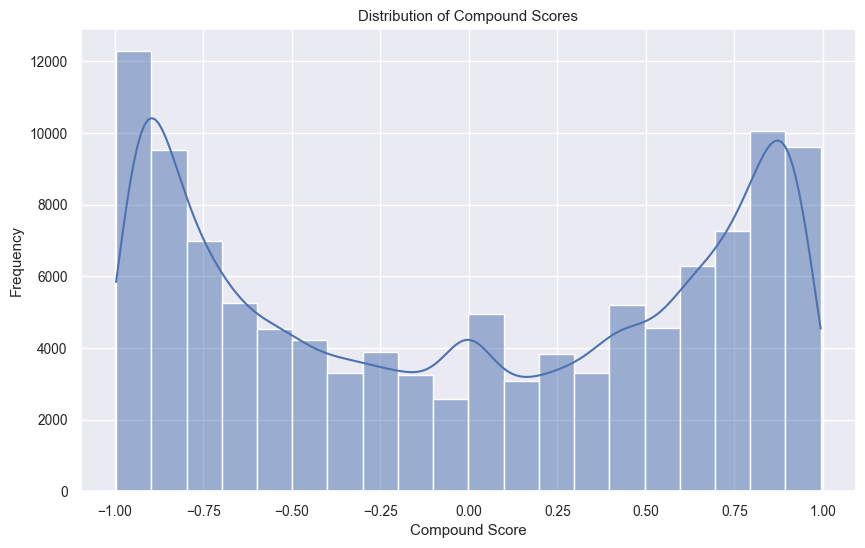

In [190]:
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_data['compound'], bins=20, kde=True)
plt.title('Distribution of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

In this code block, the top 10 most reviewed drugs are identified, and their average compound scores are visualized. Firstly, the code calculates the number of occurrences of each drug in the 'sentiment_data' DataFrame and selects the top 10 drugs with the highest counts. Then, it retrieves the data corresponding to these top 10 drugs and visualizes their average compound scores using a bar plot.

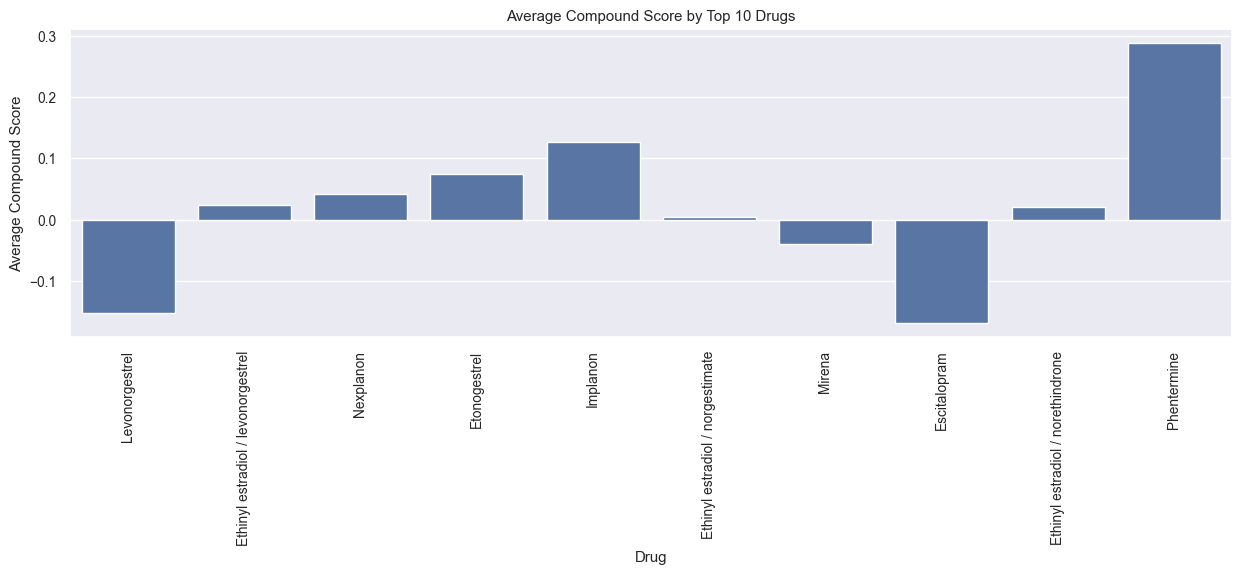

In [193]:
top_10_drugs = sentiment_data['drugName'].value_counts().nlargest(10).index
top_10_df = sentiment_data[sentiment_data['drugName'].isin(top_10_drugs)]

plt.figure(figsize=(15, 4))
sns.barplot(x='drugName', y='compound', data=top_10_df, ci=None)
plt.title('Average Compound Score by Top 10 Drugs')
plt.xlabel('Drug')
plt.ylabel('Average Compound Score')
plt.xticks(rotation=90)
plt.show()

Upon examining the visualization, it's observed that some drugs have negative average compound scores. For instance, drugs like Levonorgestrel and Escitalopram exhibit negative compound scores, indicating that these drugs are generally associated with negative evaluations. This might suggest that these drugs elicit unfavorable sentiments among users or are linked to specific adverse effects. Such insights provide valuable understanding regarding the effectiveness and user experience of these drugs.

Moreover, it's noteworthy that Phentermine has the highest average compound score among the top 10 drugs, indicating a more positive sentiment associated with this drug compared to others.

In this segment of code, the top 5 most reviewed drugs are identified, and the distribution of positive, negative, and neutral sentiment scores for these drugs is visualized using box plots. Firstly, the code calculates the number of occurrences of each drug in the 'sentiment_data' DataFrame and selects the top 5 drugs with the highest counts. Then, it retrieves the data corresponding to these top 5 drugs and prepares it for visualization by melting the DataFrame to have a single column for sentiment types (positive, negative, neutral) and their corresponding scores.

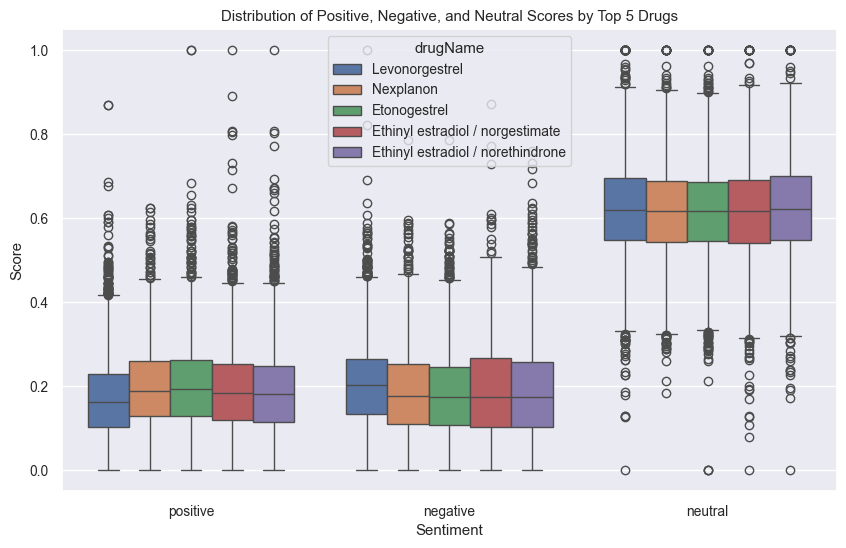

In [192]:
top_5_drugs = sentiment_data['drugName'].value_counts().nlargest(5).index
top_5_df = sentiment_data[sentiment_data['drugName'].isin(top_5_drugs)]

plt.figure(figsize=(10, 6))
df_melted = top_5_df.melt(id_vars=['drugName'], value_vars=['positive', 'negative', 'neutral'], 
                          var_name='Sentiment', value_name='Score')
sns.boxplot(x='Sentiment', y='Score', hue='drugName', data=df_melted)
plt.title('Distribution of Positive, Negative, and Neutral Scores by Top 5 Drugs')
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.show()

The resulting box plots provide insights into the distribution of sentiment scores across the top 5 drugs. They illustrate the variability and central tendency of positive, negative, and neutral sentiments associated with each drug. This visualization aids in understanding the diversity of user opinions and experiences regarding these drugs. Additionally, it enables the identification of potential patterns or trends in sentiment distributions, which can inform further analysis and decision-making in pharmaceutical research and healthcare management.

# Conclusion

In this project, a comprehensive analysis of drug reviews was undertaken with the aim of gaining insights into patient sentiments, identifying trends in drug usage, and building predictive models for health conditions.

The preprocessing tasks, such as text cleaning, tokenization, and sentiment analysis using Natural Language Processing (NLP) techniques, were performed extensively to extract valuable information from the raw text data and prepare it for further analysis.

The dataset was explored to understand the distribution of ratings, conditions, and sentiments associated with different drugs. Visualizations such as histograms, bar plots, and pie charts were utilized to provide clear representations of these distributions, facilitating a deeper understanding of the dataset.

Furthermore, machine learning models were developed to predict health conditions based on drug reviews. Various classification algorithms, including Logistic Regression, Decision Trees, Support Vector Machines, and Random Forests, were employed, resulting in high accuracy in predicting health conditions across different categories such as Mental Health, Physical Health, Specialized Health, and Birth Control.

Hyperparameter tuning was conducted to optimize the performance of the models, although in some cases, better results were obtained with default parameters, as observed during experimentation.

Additionally, valuable insights into the overall sentiment polarity of drug reviews were provided through sentiment analysis, allowing the general sentiment trends to be gauged and drugs with particularly positive or negative sentiments to be identified.

Overall, the power of data-driven approaches in healthcare analytics was demonstrated, showcasing how data science techniques can be leveraged to extract meaningful insights from unstructured text data and inform decision-making processes in the pharmaceutical domain. Through the analyses conducted, contributions were made to a better understanding of patient experiences, drug effectiveness, and sentiment dynamics in the healthcare landscape.